# ML Experiments in "Algebraic and Geometric Models for Space Networks"

In [18]:
from os_utilities import make_folder

from orb_builder import *
import soap_utilities as su
import report_parser as rp
import slice_analysis_nx as sanx # network x based
import slice_analysis as sagt # graph-tools based
from distances_tvg import *
from matrix import *
from ml_knn import *

from tqdm import tqdm
from datetime import datetime
import itertools


In [19]:
folder_base = f"./outputs/experiments"
make_folder(folder_base)

starlink = build_satellites_csv("starlink")
moon_sats = get_moon_platforms()
mars_sats = get_mars_platforms()
ground = [
    create_ground_object_dictionary("Ground-Albany", 42.685012663456163, -73.82479012295363, 0),
    create_ground_object_dictionary("Ground-Sydney", -33.868888888888889, 151.20939697339508, 0)
]
norad = build_satellites_from_tle("./sources/tdrss.tle")

def generate_orb_files(folder_name, name, satellites, date):
        save_to_outputs_file(
                generate_orb(satellites, name, date),
                f"experiments/{folder_name}/{name}", "orb")
        return name + ".orb"

## Average of $L(\mu^k)(i, j) = $ sum of intervals in entry $(i, j)$

Running Lifetime Matrix Simulations on Date = 2023-04-05 20:52:08.944889
Generating ORB Files
Running SOAP on ORB files
Constructing Matrices from ORB Files
Average Dimension of 5-Satellite TVG Matrices is 4.8
Average Dimension of 10-Satellite TVG Matrices is 9.8
Average Dimension of 15-Satellite TVG Matrices is 14.6
Average Dimension of 20-Satellite TVG Matrices is 20.0
Calculating Walks
Calculating Walks for 5 5-Satellite Systems


100%|██████████| 5/5 [00:00<00:00, 23.64it/s]


Calculating Walks for 5 10-Satellite Systems


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


Calculating Walks for 5 15-Satellite Systems


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Calculating Walks for 5 20-Satellite Systems


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


Calculating Distances
Plotting Aggregates Overlay and Confidence Interval


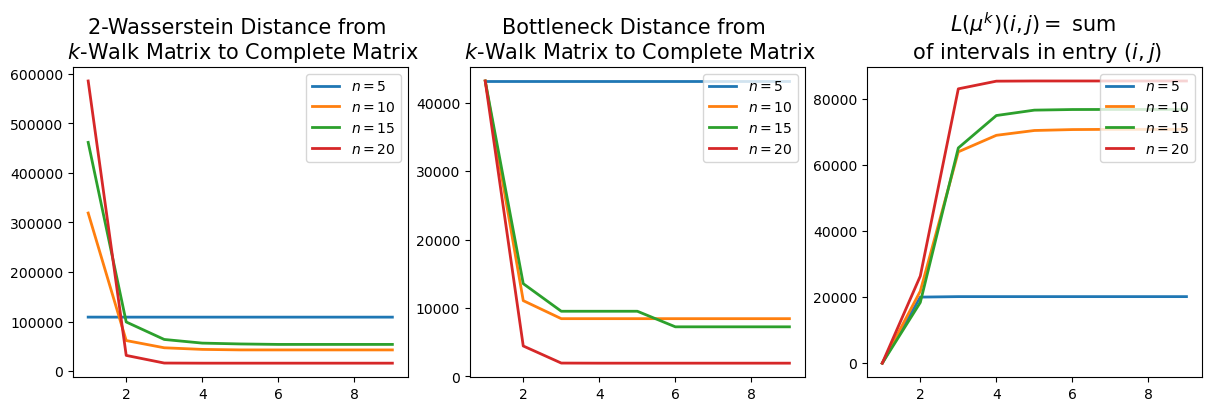

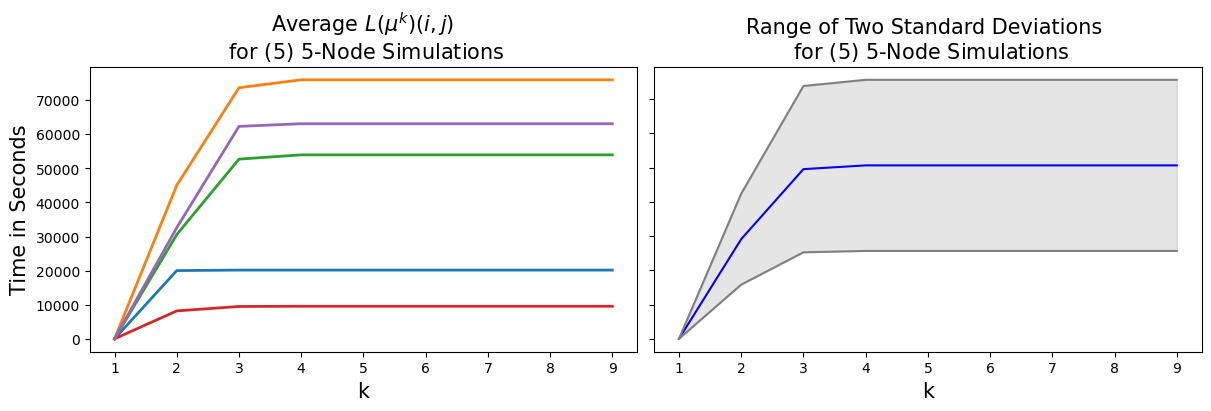

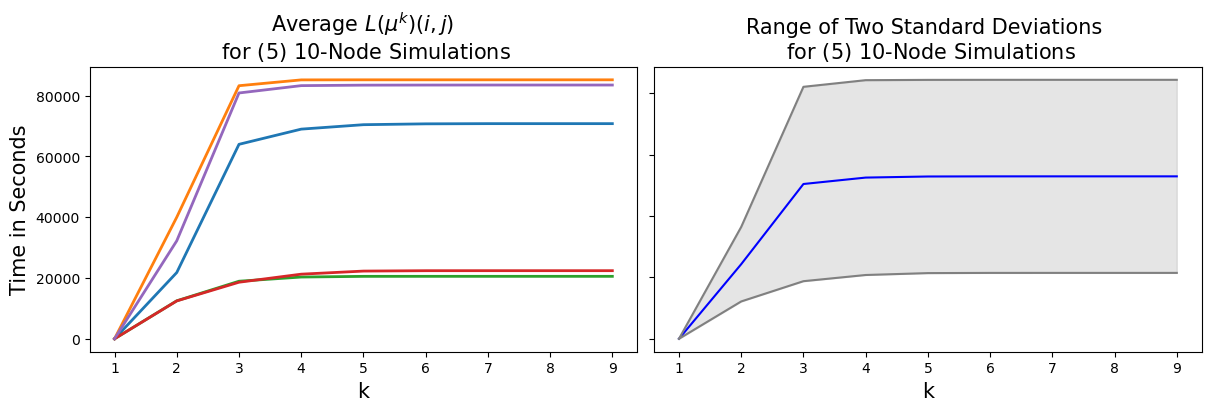

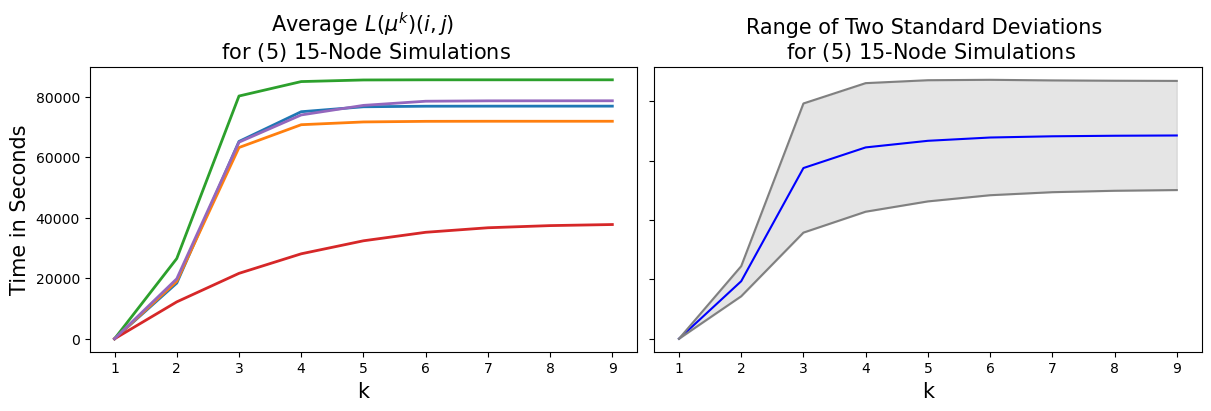

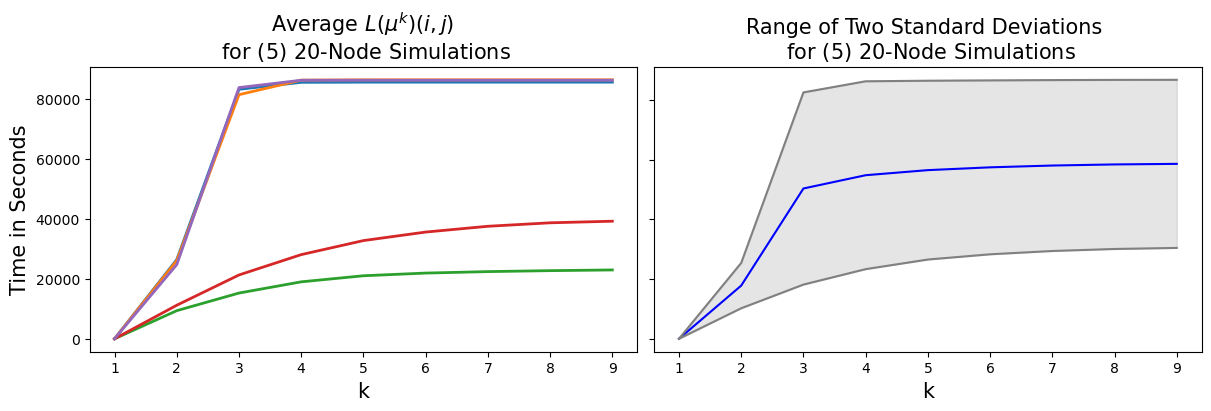

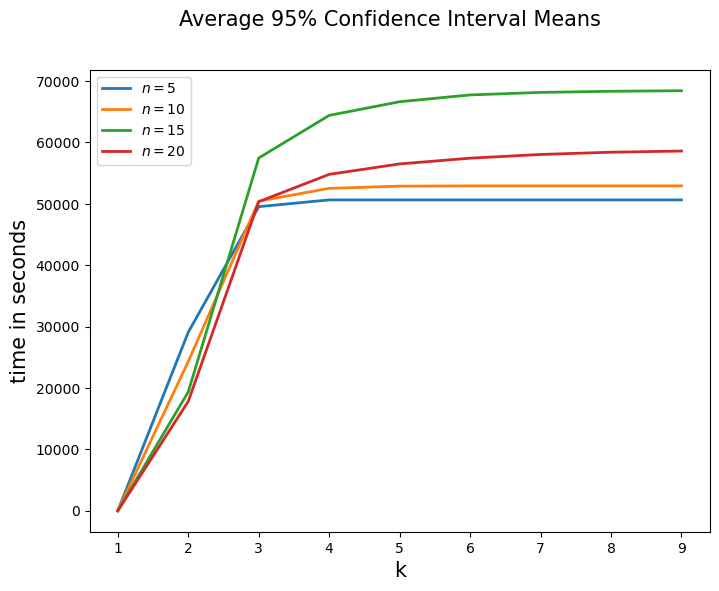

In [29]:
# n_list = [20, 30, 40, 50, 70, 100] # Figure 5, 7
# n_list = [5, 10, 15, 20, 25, 30, 35, 40] # Figure 8
n_list = [5, 10, 15, 20]
# simulation_count = 30
simulation_count = 5

date = datetime.now()
print(f"Running Lifetime Matrix Simulations on Date = {date}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]
for i, n in enumerate(n_list):
    
    folder_name = f"lt-starlink-{n}-sat-single"
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth Simulations
    for j in range(simulation_count):
        name = f"starlink_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink, n),
            date)
            
        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

print("Running SOAP on ORB files")
# su.run_soap_mac(orb_paths_flat, max_workers=10)

print(f"Constructing Matrices from ORB Files")
A = [[] for n in n_list]
B = [[] for n in n_list]
m = [[] for n in n_list] # dimensions of the matrices

for i, n in enumerate(n_list):
    # diagrams[i] = {}
    dim_sum = 0
    for path in orb_paths[i]:
        filepath = path.replace(".orb", " Contact Analysis.csv")

        matrix = rp.soap_converter(filepath)
        A[i].append(matrix)
        B[i].append(IntervalMatrix.complete_matrix(matrix.dim_row))
        m[i].append(matrix.dim_row)

        dim_sum += matrix.dim_row

    print(f"Average Dimension of {n}-Satellite TVG Matrices is {dim_sum / len(orb_paths[i])}")

print(f"Calculating Walks")

start_time, end_time = 0, 86400

walk_length = 10
walks = [[] for n in n_list]

for i, n in enumerate(n_list):
    
    print(f"Calculating Walks for {len(orb_paths[i])} {n}-Satellite Systems")
    for j, path in enumerate(tqdm(orb_paths[i])):
        walks[i].append([IntervalMatrix.identity_matrix(m[i][j])])

        # print(f"Calculating Walks for {j}-th {n}-Satellite System")
        for k in range(1, walk_length):
            # print("\tCalculating {}-Walks for {}-th {}-Sat system".format(k, i, n))
            if k == 1:
                A_k = A[i][j]
            else:
                A_k = A[i][j] * walks[i][j][-1]

            walks[i][j].append(A_k)

# Calculating Distances
print(f"Calculating Distances")
lifetime_list = [[] for n in n_list]
bdist = [None for n in n_list]
wdist_2 = [None for n in n_list]

for i, n in enumerate(n_list):
    bdist[i] = [None for j in orb_paths[i]]
    wdist_2[i] = [None for j in orb_paths[i]]

    for j, path in enumerate(orb_paths[i]):
        bdist[i][j] = [-1 for k in range(1, walk_length)]
        wdist_2[i][j] = [-1 for k in range(1, walk_length)]

        for k in range(1, walk_length):
            A_k = walks[i][j][k]
            B_k = B[i][j]
            # B_k = IntervalMatrix.complete_matrix(n)

            diagram_a_k = tvg_to_complement_diagram_matrix(A_k, start_time, end_time)
            diagram_b_k = tvg_to_complement_diagram_matrix(B_k, start_time, end_time)

            distance = tvg_interval_bottleneck_distance_matrix(diagram_a_k, diagram_b_k, m[i][j])
            bdist[i][j][k - 1] = sup_norm(distance)

            distance = tvg_interval_wasserstein_distance_matrix(diagram_a_k, diagram_b_k, m[i][j], 2)
            wdist_2[i][j][k - 1] = q_norm(distance, 2)

        # Lifetime Matrix
        L = tvg_lifetime_matrix(walks[i][j], start_time, end_time, walk_length)

        y_list = generate_y_list(L, walks[i][j][0].dim_row, walk_length)
        y_list_average = calculate_y_list_average(y_list, walk_length)
        lifetime_list[i].append(y_list_average)

# Plot Aggregates
print(f"Plotting Aggregates Overlay and Confidence Interval")

x = list(range(1, walk_length))

# Plot Wasserstein and Bottleneck Distances to Complete Matrices (First, j=0)
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 4))
axs[0].set_title(f"2-Wasserstein Distance from \n $k$-Walk Matrix to Complete Matrix", fontsize=15)
axs[1].set_title(f"Bottleneck Distance from \n $k$-Walk Matrix to Complete Matrix", fontsize=15)
axs[2].set_title(f"$L(\mu^k)(i, j) = $ sum \n of intervals in entry $(i, j)$", fontsize=15)

for i, n in enumerate(n_list):
    distance = wdist_2[i][0]
    axs[0].plot(x, distance, linewidth=2, label=f"$n = {n}$")

    distance = bdist[i][0]
    axs[1].plot(x, distance, linewidth=2, label=f"$n = {n}$")

    coverage = lifetime_list[i][0][1:]
    axs[2].plot(x, coverage, linewidth=2, label=f"$n = {n}$")

axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")
axs[2].legend(loc="upper right")

plt.savefig(f"{folder_base}/algebraic_distances_overlay_today_test.png")
plt.show()

# Plot Lifetime Distances and Confidence Intervals
mean_list = [[] for n in n_list]
for i, n in enumerate(n_list):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

    # axs[0].set_xlabel("k", fontsize=15)
    # axs[0].set_ylabel('Time in Seconds', fontsize=15)
    axs[0].set_title(f"Average $L(\mu^k)(i, j)$ \n for $({len(orb_paths[i])})$ ${n}$-Node Simulations", fontsize=15)

    # ax1.plot(x, lifetime_list[i][0][1:], linewidth=2) # plot first only
    for j, path in enumerate(orb_paths[i]):
        axs[0].plot(x, lifetime_list[i][j][1:], linewidth=2)
    # labels.append(f"$n = {n}$")

    lower_list = []
    upper_list = []

    for k in range(1, walk_length):
        data = []
        for j in range(1, len(lifetime_list[i])):
            data.append(lifetime_list[i][j][k])
        # mean, lower, upper = confidence_interval(data)
        mean, lower, upper = error_bars(data)
        
        mean_list[i].append(mean)
        lower_list.append(lower)
        upper_list.append(upper)

    # axs[1].set_xlabel("k", fontsize=15)
    # axs[1].set_ylabel("Time in Seconds", fontsize=15)
    axs[1].set_title(f"Range of Two Standard Deviations \n for $({len(orb_paths[i])})$ {n}-Node Simulations", fontsize=15)

    axs[1].plot(x, mean_list[i], color="blue")
    axs[1].plot(x, lower_list, color="grey")
    axs[1].plot(x, upper_list, color="grey")

    for ax in axs.flat:
        ax.set_xlabel("k", fontsize=15)
        ax.set_ylabel("Time in Seconds", fontsize=15)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.fill_between(x, lower_list, upper_list, color='grey', alpha=0.2)
    plt.savefig(f"{folder_base}/average_lifetime_matrix_{n}_sats_today.png")
    plt.show()

labels = []
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("time in seconds", fontsize=15)
fig.suptitle("Average 95% Confidence Interval Means", fontsize=15)
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(x, mean_list[i], linewidth=2)
plt.legend(labels)
plt.savefig(f"{folder_base}/average_lifetime_matrix_aggregates_today.png")
plt.show()

### KNN on Earth/Moon and Earth/Mars Simulations (Single Day)

Running KNN Simulations on Date = 2023-04-03 10:51:30.102574


INFO:soap_utilities:Running `run_soap_mac` with 500 simulations on 10 threads.
INFO:soap_utilities:Running `execute_commands` with 500 commands and 2 hacks.


Running SOAP on ORB files


31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to 

Average Points in Dgm[1] is 176.34
Average Points in Dgm[1] is 424.5
Average Points in Dgm[1] is 712.5
Average Points in Dgm[1] is 1508.5
Average Points in Dgm[1] is 4412.38
Calculating 5 instances of `distance_matrix_function`


100%|██████████| 5/5 [3:30:25<00:00, 2525.14s/it]


Calculating Accuracies Single 80:20 Split for each `n`


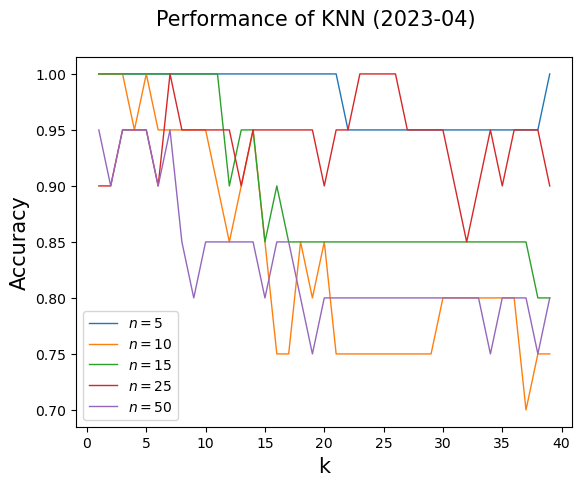

Calculating Accuracies 100 80:20 Splits for each `n`


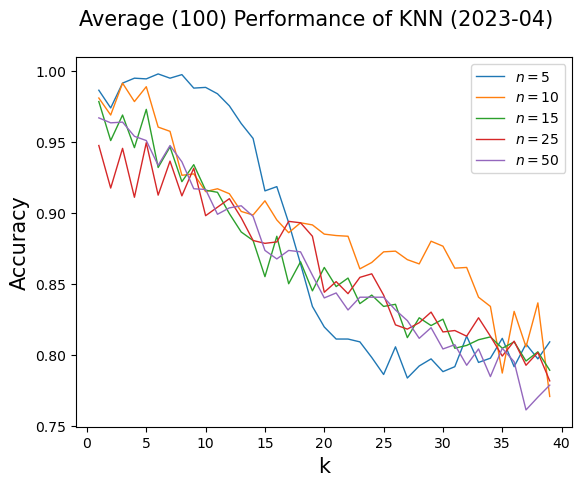

In [4]:
n_list = [5, 10, 15, 25, 50]
# n_list = [5, 10, 15]
simulation_count = 50 # number of simulations to run for each `n`
# simulation_count = 5

date = datetime.now()
print(f"Running KNN Simulations on Date = {date}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]

for i, n in enumerate(n_list):
    folder_name = f"knn-starlink-{n}-moon-{simulation_count}-mars-{simulation_count}"
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth / Moon Simulations
    for j in range(simulation_count):
        name = f"starlink_moon_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink, n) + moon_sats,
            date)

        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

    # Generate Earth / Mars Simulations
    for j in range(simulation_count):
        name = f"starlink_mars_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink, n) + mars_sats,
            date)

        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

# for path in orb_paths_flat:
#     print(path)

print("Running SOAP on ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

EARTH, MOON, MARS = 0, 1, 2 # labels for KNN

diagrams = [{} for n in n_list]
x = [[] for n in n_list]
y = [[] for n in n_list]

for i, n in enumerate(n_list):
    # diagrams[i] = {}
    dgm_sum = 0
    for path in orb_paths[i]:
        filepath = path.replace(".orb", " Contact Analysis.csv")

        contact_plan = rp.contact_analysis_parser(filepath)
        graph = rp.construct_graph(contact_plan, delta = 1)    
        weighted_simplex = rp.construct_weighted_simplex(graph)
        
        zz, dgms, cells = calculate_zz_persistence(weighted_simplex)

        filename = filepath.split("/")[-1]

        diagrams[i][filename] = {
            "dgms" : dgms,
            "id" : len(x[i])
        }
        dgm_sum += len(dgms[1])

        x[i].append(filename)
        label = -1
        if "moon" in filename:
            label = MOON
        elif "mars" in filename:
            label = MARS
        else:
            label = EARTH

        y[i].append(label)

    print(f"Average Points in Dgm[1] is {dgm_sum / len(orb_paths[i])}")

dim = 1

print(f"Calculating {len(n_list)} instances of `distance_matrix_function`")

distance_matrix_functions = [None for n in n_list]
for i, n in enumerate(tqdm(n_list)):
    # print(f"\tCalculating `distance_matrix_function[{i}]`")
    distance_matrix_functions[i] = distance_matrix_lambda_function(diagrams[i], x[i], y[i], dim = dim)

print(f"Calculating Accuracies Single 80:20 Split for each `n`")

ks = range(1, 40)

accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
    
    for k in ks:
        knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
        knn.fit(x_train, y_train)
        accuracy = knn.evaluate(x_test, y_test)
        accuracies[i].append(accuracy)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Performance of KNN ({date.strftime('%Y-%m')})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_single_overlay_today.png")
plt.show()

m = 100 
print(f"Calculating Accuracies {m} 80:20 Splits for each `n`")

ks = range(1, 40)
accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    for k in ks:
        k_accuracies = []
        for j in range(m):
            x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
            knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
            knn.fit(x_train, y_train)
            accuracy = knn.evaluate(x_test, y_test)
            # accuracies[i].append(accuracy)
            k_accuracies.append(accuracy)
        average = sum(k_accuracies) / len(k_accuracies)
        accuracies[i].append(average)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Average ({m}) Performance of KNN ({date.strftime('%Y-%m')})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_average_training_overlay_today.png")
plt.show()

### Slice Analysis

In [31]:
n_list = [50]
simulation_count = 30

date = datetime.now()
print(f"Running Slice Analysis Simulations on Date = {date}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]
for i, n in enumerate(n_list):
    
    folder_name = f"slice-starlink-{n}-sat-single"
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth Simulations
    for j in range(simulation_count):
        name = f"starlink_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink, n),
            date)
            
        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

print("Running SOAP on ORB files")
# su.run_soap_mac(orb_paths_flat, max_workers=10)

# critical_times = [None for n in n_list]
for i, n in enumerate(n_list):

    # critical_times[i] = [None for j in orb_paths[i]]
    for j, path in enumerate(orb_paths[i]):

        filepath = path.replace(".orb", " Contact Analysis.csv")

        contact_plan = rp.contact_analysis_parser(filepath)
        tvg = rp.construct_graph(contact_plan, delta = 1)
        # critical_times[i][j] = rp.extract_critical_times(graph)
        critical_times = rp.extract_critical_times(tvg)
        sample_times = rp.sample_critical_times(critical_times)

        diameters = []
        for time in sample_times:
            graph = sanx.get_graph_slice_at(tvg, time)
            diameters.append(sanx.get_diameter(graph))
            
        # print(f"NX : {n}-sats-{j} : (min,avg,max)=({min(diameters)},{sum(diameters)/len(diameters)},{max(diameters)})")
        print(f"NX : {n}-sats-{j} : max={max(diameters)} (out of {len(sample_times)} slices)")

        diameters = []
        for time in sample_times:
            graph = sagt.get_graph_slice_at(tvg, time)
            diameters.append(sagt.get_diameter(graph))

        # print(f"GT : {n}-sats-{j} : (min,avg,max)=({min(diameters)},{sum(diameters)/len(diameters)},{max(diameters)})")



Running Slice Analysis Simulations on Date = 2023-04-05 20:56:44.456107
Generating ORB Files
Running SOAP on ORB files
NX : 50-sats-0 : max=5 (out of 5012 slices)
NX : 50-sats-1 : max=7 (out of 5214 slices)
NX : 50-sats-2 : max=18 (out of 4282 slices)
NX : 50-sats-3 : max=5 (out of 5530 slices)
NX : 50-sats-4 : max=14 (out of 5533 slices)
NX : 50-sats-5 : max=9 (out of 5224 slices)
NX : 50-sats-6 : max=7 (out of 4701 slices)
NX : 50-sats-7 : max=14 (out of 5078 slices)
NX : 50-sats-8 : max=12 (out of 5173 slices)
NX : 50-sats-9 : max=9 (out of 5703 slices)
NX : 50-sats-10 : max=15 (out of 4754 slices)
NX : 50-sats-11 : max=7 (out of 4919 slices)
NX : 50-sats-12 : max=8 (out of 6004 slices)
NX : 50-sats-13 : max=20 (out of 4787 slices)
NX : 50-sats-14 : max=11 (out of 4748 slices)
NX : 50-sats-15 : max=10 (out of 4528 slices)
NX : 50-sats-16 : max=11 (out of 4808 slices)
NX : 50-sats-17 : max=6 (out of 5301 slices)
NX : 50-sats-18 : max=7 (out of 4138 slices)
NX : 50-sats-19 : max=9 (ou